In [1]:
# Copyright 2023 LIN Yi. All Rights Reserved.
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

import os
os.chdir('../main')
import sys
from args import get_args

import retro
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import CheckpointCallback
from stable_baselines3.common.vec_env import SubprocVecEnv

#from street_fighter_custom_wrapper import StreetFighterCustomWrapper
from street_fighter_84x84_wrapper import StreetFighterCustomWrapper

import wandb
from wandb.integration.sb3 import WandbCallback


# Linear scheduler
def linear_schedule(initial_value, final_value=0.0):

    if isinstance(initial_value, str):
        initial_value = float(initial_value)
        final_value = float(final_value)
        assert (initial_value > 0.0)

    def scheduler(progress):
        return final_value + progress * (initial_value - final_value)

    return scheduler

def make_env(game, state, seed=0):
    def _init():
        env = retro.make(
            game=game, 
            state=state, 
            use_restricted_actions=retro.Actions.FILTERED, 
            obs_type=retro.Observations.IMAGE    
        )
        env = StreetFighterCustomWrapper(env)
        env = Monitor(env)
        env.seed(seed)
        return env
    return _init

In [2]:
stage_map = {
    1:'Champion.Level01.RyuVsRyu', #0
    2:'Champion.Level02.RyuVsHonda', #1
    3:'Champion.Level03.RyuVsBlanka',#2
    3.5:'Champion.Level03.5Bonus1',#3
    4:'Champion.Level04.RyuVsGuile',#3
    5:'Champion.Level05.RyuVsKen',#4
    6:'Champion.Level06.RyuVsChunLi',#5
    6.5:'Champion.Level06.5Bonus2',#6
    7:'Champion.Level07.RyuVsZangief',#6
    8:'Champion.Level08.RyuVsDalsim',#7
    9:'Champion.Level09.RyuVsBalrog',#8
    9.5:'Champion.Level09.5Bonus3',#9
    10:'Champion.Level10.RyuVsVega',#9
    11:'Champion.Level11.RyuVsSagat',#10
    12:'Champion.Level12.RyuVsBison',#11
    }

In [3]:
class Args:
    game = 'StreetFighterIISpecialChampionEdition-Genesis'
    state = stage_map[1]#'Champion.Level12.RyuVsBison'
    num_env = 16
    n_steps = 512
    total_timesteps = 10000000
    check_timesteps = 500000
    reset_round = 1
    rd_type = 'default'
    eval_reset_round = 1
    log_dir = 'logs'
    train_name = 'PPO'
    disable_wandb = False



args = Args()

In [4]:
def make_env(game, state):
    def _init():
        env = retro.make(
            game=game, 
            state=state, 
            use_restricted_actions=retro.Actions.FILTERED,
            obs_type=retro.Observations.IMAGE
        )
        env = StreetFighterCustomWrapper(env)
        return env
    return _init

In [6]:
from pyvirtualdisplay import Display

virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

%matplotlib inline
import matplotlib.pyplot as plt

from IPython import display

In [17]:
info

{'enemy_x': 403,
 'enemy_hp': 176,
 'enemy_y': 192,
 'enemy_victories': 0,
 'level': 3,
 'round_countdown': 37645,
 'reset_countdown': 0,
 'score': 137200,
 'agent_y': 130,
 'enemy_character': 3,
 'agent_status': 526,
 'agent_hp': 152,
 'enemy_status': 522,
 'agent_victories': 0,
 'agent_x': 193}

2 Lose...

Fighting Ends!

Winning rate: 0.0
Average reward for random action: -0.17600000000000002


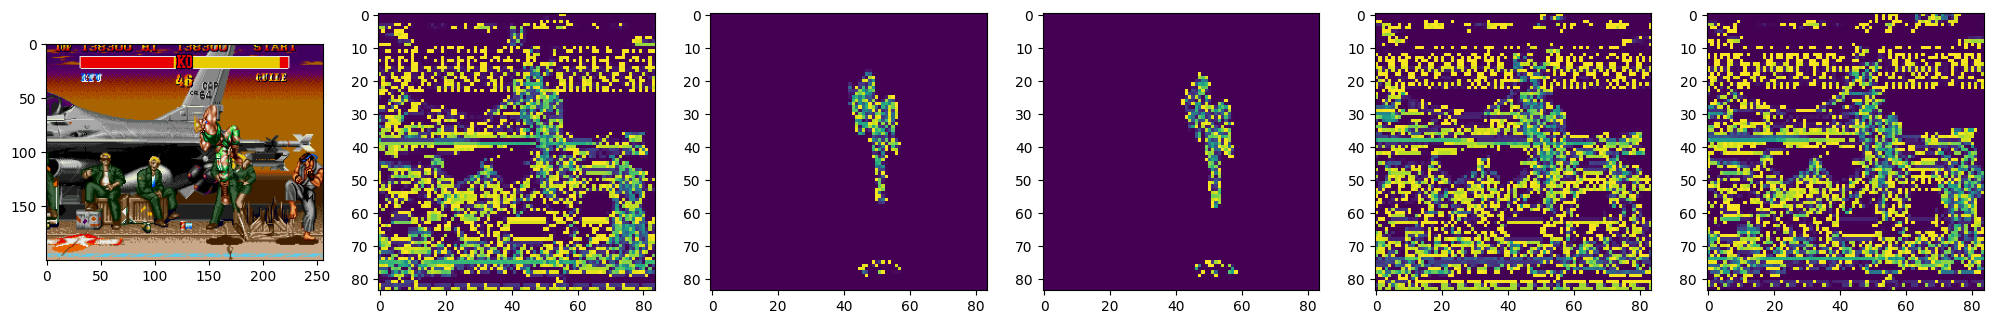

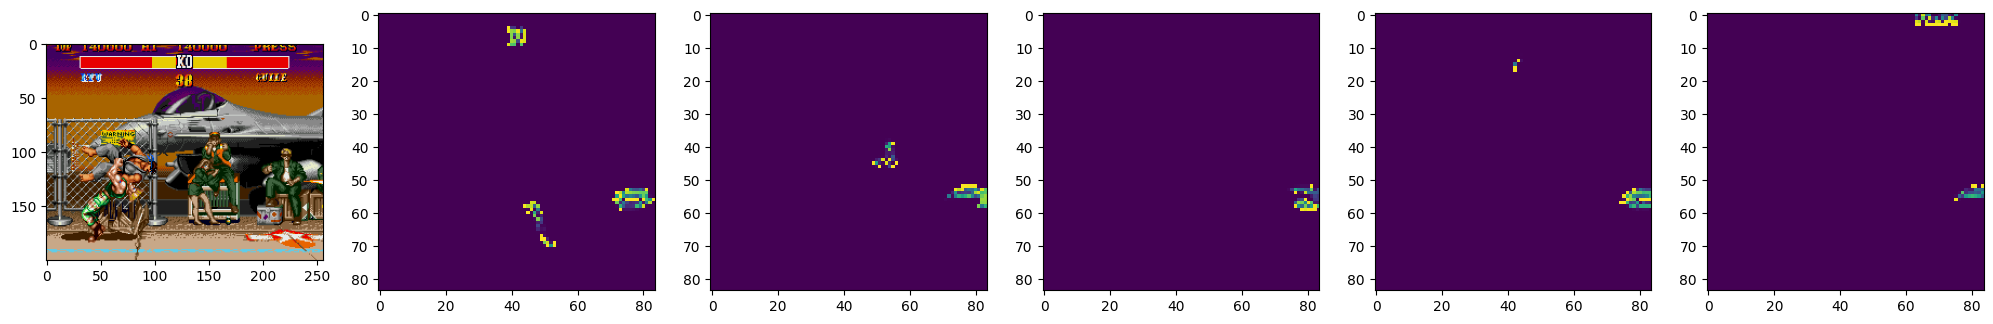

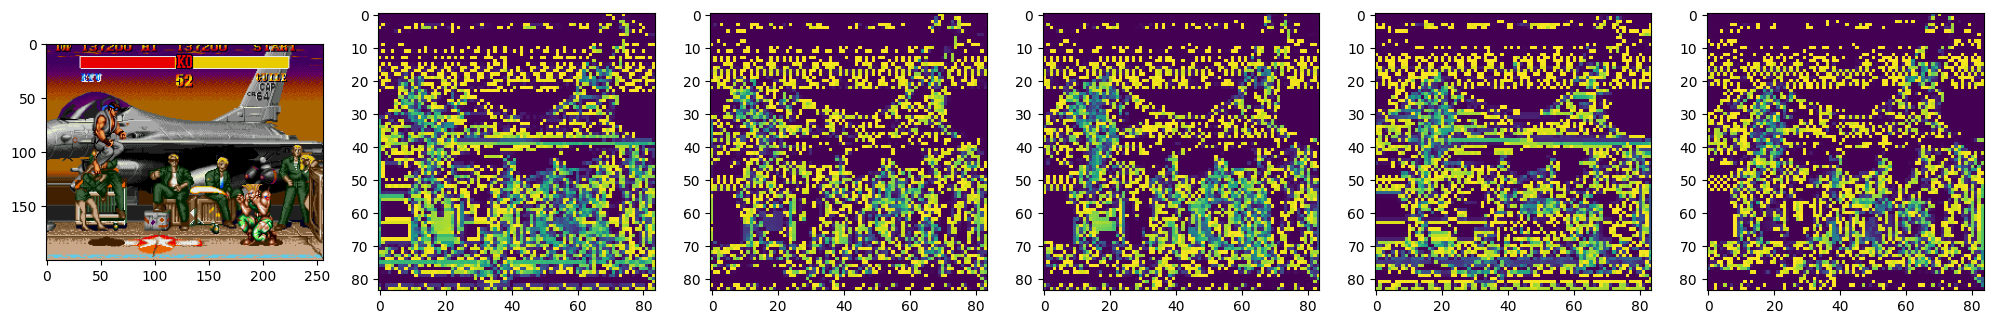

In [7]:
import numpy as np
import time
RENDERING = True
RESET_ROUND = True
env = make_env(args.game, state=stage_map[4])()
obs = env.reset()
done = False

num_episodes = 3
episode_reward_sum = 0
num_victory = 0

print("\nFighting Begins!\n")

for _ in range(num_episodes):
    done = False
    
    obs = env.reset()
    total_reward = 0

    fig = plt.figure(figsize=(25, 5))
    steps = 0
    while not done and steps < 3000:
        timestamp = time.time()
        obs, reward, done, info = env.step(env.action_space.sample())

        if reward != 0:
            total_reward += reward
            # print("Reward: {:.3f}, playerHP: {}, enemyHP:{}".format(reward, info['agent_hp'], info['enemy_hp']))
        
        # done should be returned by env.step() when the game is over
        # if info['enemy_hp'] < 0 or info['agent_hp'] < 0:
        #     done = True

        if RENDERING and steps%10==0:
            plt.subplot(161)
            real = env.render(mode='rgb_array')
            plt.imshow(real)

            plt.subplot(162)
            plt.imshow(obs[0])

            plt.subplot(163)
            plt.imshow(obs[1])

            plt.subplot(164)
            plt.imshow(obs[2])

            plt.subplot(165)
            plt.imshow(obs[3])

            plt.subplot(166)
            plt.imshow(obs[4])



            
            display.display(plt.gcf())
            time.sleep(0.2)
            display.clear_output(wait=True)
        steps +=1
        print(f'lv:{info["level"]}, rwd:{reward}, me hp:{info["agent_hp"]}, he hp:{info["enemy_hp"]}, sec:{info["round_countdown"]}\r', end='')
            

    if info['enemy_hp'] < 0:
        print(_, "Victory!")
        num_victory += 1
    else:
        print(_, "Lose...")

    # print("Total reward: {}\n".format(total_reward))
    episode_reward_sum += total_reward

    if not RESET_ROUND:
        while info['enemy_hp'] < 0 or info['agent_hp'] < 0:
        # Inter scene transition. Do nothing.
            obs, reward, done, info = env.step([0] * 12)
            if RENDERING:
                env.render(mode='rgb_array')

env.close()

print("\nFighting Ends!\n")
#print(model_checkpoints)
print("Winning rate: {}".format(1.0 * num_victory / num_episodes))
print("Average reward for random action: {}".format(episode_reward_sum/num_episodes))


env.close()

In [30]:
env.close()

In [ ]:
def main(args):
    # Hyperparameters
    NUM_ENV = args.num_env # 16
    
    # used for saving checkpoints and logs
    LOG_DIR = args.log_dir
    os.makedirs(LOG_DIR, exist_ok=True)
    model_name = args.train_name

    # Set up the environment and model
    game = args.game #"StreetFighterIISpecialChampionEdition-Genesis"
    env = SubprocVecEnv([make_env(game, state=args.state, seed=i) for i in range(NUM_ENV)])

    # Start
    # Set linear scheduler for clip range
    clip_range_schedule = linear_schedule(0.15, 0.025)
    # Set linear schedule for learning rate
    lr_schedule = linear_schedule(2.5e-4, 2.5e-6)

    # fine-tune
    # lr_schedule = linear_schedule(5.0e-5, 2.5e-6)
    # fine-tune
    # clip_range_schedule = linear_schedule(0.075, 0.025)

    n_steps = args.n_steps # 512
    model = PPO(
        "CnnPolicy", 
        env,
        device="cuda", 
        verbose=1,
        n_steps=n_steps,
        batch_size=n_steps*NUM_ENV,
        n_epochs=4,
        gamma=0.94,
        learning_rate=lr_schedule,
        clip_range=clip_range_schedule,
        tensorboard_log="logs"
    )

    # Set the save directory
    save_dir = "trained_models_" + model_name
    os.makedirs(save_dir, exist_ok=True)

    # Load the model from file
    # model_path = "trained_models/ppo_ryu_7000000_steps.zip"
    
    # Load model and modify the learning rate and entropy coefficient
    # custom_objects = {
    #     "learning_rate": lr_schedule,
    #     "clip_range": clip_range_schedule,
    #     "n_steps": 512
    # }
    # model = PPO.load(model_path, env=env, device="cuda", custom_objects=custom_objects)

    # Set up callbacks
    # Note that 1 timesetp = 6 frame
    total_timesteps = args.total_timesteps # 10000000
    check_timesteps = args.check_timesteps # 500000
    checkpoint_interval = check_timesteps / NUM_ENV # checkpoint_interval * num_envs = total_steps_per_checkpoint
    checkpoint_callback1 = CheckpointCallback(save_freq=checkpoint_interval, save_path=save_dir, name_prefix=model_name)
    checkpoint_callback2 = WandbCallback(
        gradient_save_freq=1000,
        # model_save_freq = checkpoint_interval,
        # model_save_path=f"{save_dir}/{run.id}",
        # verbose=1,
    ) if not args.disable_wandb else None

    # Writing the training logs from stdout to a file
    original_stdout = sys.stdout
    log_file_path = os.path.join(save_dir, "training_log.txt")
    with open(log_file_path, 'w') as log_file:
        sys.stdout = log_file
    
        model.learn(
            total_timesteps=int(total_timesteps), # total_timesteps = stage_interval * num_envs * num_stages (1120 rounds)
            callback=[checkpoint_callback1, checkpoint_callback2] if not args.disable_wandb else [checkpoint_callback1] #, stage_increase_callback]
        )
        env.close()

    # Restore stdout
    sys.stdout = original_stdout

    # Save the final model
    model.save(os.path.join(save_dir, model_name+".zip"))

if __name__ == "__main__":
    #args = get_args()

    if not args.disable_wandb:
        if 'WANDB_BASE_URL' in os.environ:
            del os.environ['WANDB_BASE_URL']
        # 先 login, 如果要切換帳號可以在 command line 打 `wandb login --relogin`
        # 這行會要求你去 https://wandb.ai/authorize 拿取屬於自己的 api key
        # 複製 api key 貼上 (即使是在同個 team 不同人會拿到不同的 key)
        wandb.login()

        # 我們的 team 是 'ntuai2023'，這個要設在 `wandb.init()` 的 `entity` 參數
        # team 底下的 project 是`sf2`
        config = {
            'algo':args.train_name,
            'total_timesteps':args.total_timesteps,
            'stage':'Level12.RyuVsBison',
        }
        WANDB_PROJECT='sf2'
        run = wandb.init(project=WANDB_PROJECT, 
                        entity='ntuai2023', 
                        config=config,
                        sync_tensorboard=True,  # auto-upload sb3's tensorboard metrics
                        monitor_gym=True,  # auto-upload the videos of agents playing the game
                        save_code=True,  # optional
                        settings=wandb.Settings(start_method="fork"))

    main(args)
